# Dataset for Pnoi experiments

> prepare master_pnoi_corpus.csv file that contains informant of entire pnoi-corpus

In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import glob
import json
import os

mkdir = lambda p: 0 if os.path.exists(p) else (os.makedirs(p), 1)[1]

## STATE VARIABLES
`IS_TEST`: if True, runs all data processing layers, else runs only the last layer

`IS_DRY_RUN`: if True, runs code without saving files, else runs code and saves files

`IS_DUMMY_PATH`: if True, uses dummy path, else uses real path

In [175]:
IS_TEST = False
IS_DRY_RUN = False
IS_DUMMY_PATH = False

## PATHS
`EXP_VER`: export version in use

`REPORTS`: reports folder name (all reports/exports are saved here)

`DATAETL`: report folder name for this notebook

`DATA_PATH`: path to raw (annotated) data folder

`REPORT_FOLDER`: path to report folder

`MUSTER_CSV_EXPORT_PATH`: dataset muster csv export file path

In [176]:
EXP_VER = "v10"

REPORTS = "0_pnoi-reports"

DATAETL = f"dataetl_{EXP_VER}"

DATA_PATH = "DATA_DUMMY" if IS_DUMMY_PATH else "DATA_PNOISTOR"

REPORT_FOLDER = f"../{REPORTS}/{DATAETL}"; mkdir(REPORT_FOLDER)

MUSTER_CSV_EXPORT_PATH = f"{REPORT_FOLDER}/pnoicorpus_muster.csv"

## Dataset Class
- List of name seperators used in file nomenclaure
- List of annotation labels
- List of file dataframe keys mapping in order

In [177]:
class DataStaticInfo:

    VER = "*"
    SEP = "-"
    META_SEP = "_"
    EXT_SEP = "."
    ANOT_LABELS = ["aa", "ee", "uu", "oo", "ii", "xx", "bb1", "bb2", "bb3", "bb4"]

    fkeys = {
        "APP_CODE": "app_code",
        "SID":"sub_id",
        "FCLASS": "file_class",
        "FID": "file_ID",
        "COMNT": "file_comment",
        "FFMT": "file_format",
        "FNAME": "file_name",
        "FPATH": "file_path",
        "FMATCH": "file_match"
    }


## Data Extraction

- input:

`DATA_PATH`: path to raw (annotated) data folder

- output:

`ALL_FILES_DF`: dataframe of all files in the raw data folder

In [178]:
class DataExtractFiles(DataStaticInfo):

    ALL_FILES_DF: pd.DataFrame
    
    def __init__(self, path: str, ver="*") -> None:
        self.VER = ver

        all_files = glob.glob(f"{path}/pnoistor_{self.VER}/*/pnoistor_*")

        self.ALL_FILES_DF = self.make_files_df(all_files)

    def file_dict(self, fpath: str) -> dict:
        _, fname = os.path.split(fpath)

        match_key = fname.split(self.EXT_SEP)[0]

        fitems = fname.replace(self.EXT_SEP, self.SEP, 1).split(self.SEP) 
        fitems += [fname, fpath, match_key]
        fdict = dict(zip(self.fkeys.values(), fitems))
        return fdict
    
    def make_files_df(self, all_files: list) -> pd.DataFrame:
        files = [self.file_dict(fp) for fp in all_files]
        return pd.DataFrame(files)
    
    def get_file_extention(self) -> str:
        return self.ALL_FILES_DF[self.fkeys["FFMT"]].unique()
    
    def get_subject_list(self) -> list:
        print("all files")
        return self.ALL_FILES_DF[self.fkeys["SID"]].unique()
    
    
def test():
    
    pnoidata_files = DataExtractFiles(DATA_PATH, ver="*")

    # logs
    print(pnoidata_files.get_subject_list().__len__(), "subjects")
    print(len(pnoidata_files.ALL_FILES_DF), "files")
    print(pnoidata_files.get_file_extention().__len__(), "file types")
    print(pnoidata_files.get_file_extention(), "file types")

    return pnoidata_files.ALL_FILES_DF.head()

test() if IS_TEST else None

## Data Source Files

- input:

`ALL_FILES_DF`: dataframe of all files in the raw data folder

- output:

`SOURCE_FILES_DF`: dataframe of all source files in the raw data folder

- source files are of format: wav, WAV, pdf, json
- each source file has a corresponding annotation file
    - Audio data: wav -> txt
    - Audio data: WAV -> txt
    - PFT report: pdf -> tsv
    - Metadata: json -> meta.json

In [179]:
class DataSourceFiles(DataExtractFiles):

    src_data_fname_regx = r"^pnoistor_(?!.*\.meta\.).+\.(wav|WAV|pdf|json|)$"

    ALL_FILES_DF: pd.DataFrame
    SOURCE_FILES_DF: pd.DataFrame

    def __init__(self, ver="*") -> None:
        super().__init__(DATA_PATH, ver=ver)
        
        PREV_FILES_DF = self.ALL_FILES_DF

        self.SOURCE_FILES_DF = self.pair_src_anot_files(PREV_FILES_DF)

    def make_source_files_df(self, df) -> pd.DataFrame:
        filt = df.loc[:, self.fkeys["FNAME"]].str.match(self.src_data_fname_regx)

        res = df[filt]
        return res
    
    def anot_path_join(self, p: pd.Series) -> str:
        fpath = os.path.join(os.path.split(p[self.fkeys['FPATH']])[0], p[f"anot--{self.fkeys['FNAME']}"])

        return fpath if os.path.exists(fpath) else False
    
    def pair_src_anot_files(self, df) -> pd.DataFrame:
        anot_format_mapping = { self.fkeys["FFMT"]: {'wav': 'txt', 'WAV': 'txt', 'pdf': 'tsv', "json": "meta.json"} }

        source_files_DF = self.make_source_files_df(df)
    
        anot_file_format_DF = source_files_DF.replace(anot_format_mapping) # anotation file extension

        # rename file_format to anot--file-format
        anot_fmt_column = f"anot--{self.fkeys['FFMT']}"
        anot_file_format_DF.rename(columns={self.fkeys["FFMT"]: anot_fmt_column}, inplace=True)
        anot_file_format_DF = anot_file_format_DF[[anot_fmt_column, self.fkeys["FMATCH"]]]
       
        
        # mergr source and anotation files
        src_data_files_DF = pd.merge(source_files_DF, anot_file_format_DF, on=self.fkeys["FMATCH"], how="left")
        anot_fname_column = f"anot--{self.fkeys['FNAME']}"

        src_data_files_DF[anot_fname_column] = src_data_files_DF[self.fkeys["FMATCH"]] + '.' + src_data_files_DF[anot_fmt_column]


        anot_fpath_column = f"anot--{self.fkeys['FPATH']}"
        anote_filepath_df = src_data_files_DF.apply(self.anot_path_join, axis=1).to_frame(name=anot_fpath_column)

        src_data_files_DF = pd.concat([src_data_files_DF, anote_filepath_df], axis=1)

        return src_data_files_DF
    
    def get_subject_list(self) -> list:
        print("source files")
        return self.SOURCE_FILES_DF[self.fkeys["SID"]].unique()

def test():
    pnoidata_source_files = DataSourceFiles()

    # logs
    print(pnoidata_source_files.get_subject_list().__len__(), "subjects")
    print(len(pnoidata_source_files.SOURCE_FILES_DF), "files")

    return pnoidata_source_files.SOURCE_FILES_DF.head()

test() if IS_TEST else None

## PFT Data Extraction

- input:

`SOURCE_FILES_DF`: dataframe of all source files in the raw data folder

- output:

`SOURCE_FILES_PFT_DF`: dataframe of all source files with PFT reports data columns

#### PFT report data columns

- PFT `values before` inhaler
    - FEV1_val_before
    - FVC_val_before
    - ratio_val_before

- PFT `reference before` inhaler
    - FEV1_ref_before
    - FVC_ref_before
    - ratio_ref_before

- PFT `values after` inhaler
    - FEV1_val_after
    - FVC_val_after
    - ratio_val_after

- PFT `reference after` inhaler
    - FEV1_ref_after
    - FVC_ref_after
    - ratio_ref_after

In [180]:
import re

class ProcessPFTFiles(DataSourceFiles):

    SOURCE_FILES_PFT_DF: pd.DataFrame

    def __init__(self, ver="*") -> None:
        super().__init__(ver=ver)
        
        self.PREV_FILES_DF = self.SOURCE_FILES_DF


        self.SOURCE_FILES_PFT_DF = self.make_pft_df(self.PREV_FILES_DF)


    def read_pft_data(self, rv):
        file_path = rv[self.fkeys["FPATH"]]
        print

        # print(f"./{file_path}")
        anot_fpath = file_path.replace(".pdf", ".tsv")
        if not os.path.exists(anot_fpath):
            return
        
        # pft_files.append(anot_fpath)

        df = pd.read_csv(anot_fpath, sep="\t")
        file_info = {
            # f"file_path": file_path,
            self.fkeys["SID"]: rv[self.fkeys["SID"]],
        }
        pft_dict = {}
        for i, row in df.iterrows():
            for col in df.columns[1:]:
                val_typ = row["PFT"]
                if 'before' in rv[self.fkeys["FNAME"]]:
                    pft_key = f"{col}_{val_typ}_{'before'}"
                else:
                    pft_key = f"{col}_{val_typ}_{'after'}"

                pft_val = df.loc[i, col]

                pft_dict[pft_key] = pft_val

        pft_dict = pft_dict | file_info

        # df_reshape =  pd.DataFrame([pft_dict])
        return pft_dict
    
    def make_pft_df(self, df) -> pd.DataFrame:

        pft_tags = ["PFT_before", "PFT_after"]

        def pft_data_df(tag: str) -> pd.DataFrame:
            filt = df[self.fkeys["FCLASS"]].str.contains(tag)
            src_PFT_data_DF = df[filt]

            pft_dict_list = [self.read_pft_data(rv) for _, rv in src_PFT_data_DF.iterrows()]
            pft_dict_list = [x for x in pft_dict_list if x is not None]; pft_dict_list
            PFT_data_DF = pd.DataFrame(pft_dict_list)
            PFT_data_DF.fillna("-", inplace=True); PFT_data_DF.columns

            return PFT_data_DF
        
        src_data_files_DF = df.copy()
        for tag in pft_tags:

            src_data_files_DF = src_data_files_DF.merge(pft_data_df(tag), how="left", on=[self.fkeys["SID"]])

        return src_data_files_DF
    

    def check_pft_typos(self) -> None:
        filt = self.PREV_FILES_DF[self.fkeys["FCLASS"]].str.contains("PFT")
        src_PFT_data_DF = self.PREV_FILES_DF[filt]

        pft_files = src_PFT_data_DF[f"anot--{self.fkeys['FPATH']}"]
        
        pat = r'\b(?:FVE1|FEv1|raf|2.97)\b'
    
        for file in pft_files:
            
            if not os.path.exists(f"{file}") : continue

            with open(file, 'r') as fp:
                content = fp.read()

                match = re.findall(pat, content)
            
                if len(match) > 0:
                    print(match, f"./{file}", "pft typos")
                    
    def get_subject_list(self) -> list:
        print("pft files")
        return self.SOURCE_FILES_PFT_DF[self.fkeys["SID"]].unique()

def test():
    pnoidata_pft_files = ProcessPFTFiles()

    # logs
    print(pnoidata_pft_files.get_subject_list().__len__(), "subjects")
    print(len(pnoidata_pft_files.SOURCE_FILES_PFT_DF), "files")

    return pnoidata_pft_files.SOURCE_FILES_PFT_DF.head()

test() if IS_TEST else None

## Meta Data Extraction

- input:

`SOURCE_FILES_PFT_DF`: dataframe of all source files with PFT reports data columns

- output:

`SOURCE_FILES_META_DF`: dataframe of all source files with PFT reports data and METADATA columns

#### METADATA data columns

- `app_code`: app version used for data collection
- `sub_id`: unique id of the subject

- `subjectName`: subject name (string)
- `subjectGender`: subject gender [M/ F/ O]
- `subjectAge`: subject age (in years)
- `subjectType`: subject type [Asthma/ COPD/ Control/ Unknown]
- `subjectHeight`: subject height (in cm)
- `subjectWeight`: subject weight (in kg)

### Example Meta Data JSON file structure

```json
"subjectBiodata": {
    "subjectGender": "Male",
    "subjectRemunerationDetails": "0",
    "subjectHeight": "0",
    "subjectType": "Patient",
    "firebaseId": "sujatan_bdd161b6",
    "subjectSectionDone": true,
    "subjectAge": "48",
    "subjectWeight": "0",
    "subjectRemunerationType": "Account No.",
    "subjectName": "Sujata N"
  },

"subjectSurvey": {
  
    "allQuestions": [
      {...},
      {...},

      ...
  ],

    "answeredQs": [
          {
            "qno": 1,
            "answer": "option1",
            "nextQnos": [2],
            "options": [
              "option1",
              "option2",
              "option3",
            ],
            "question": "What is your smoking status?"
          },

          ...
    ]
}
```

In [181]:
class ProcessMETAFiles(ProcessPFTFiles):

    # SOURCE_FILES_DF: pd.DataFrame
    SOURCE_FILES_META_DF: pd.DataFrame
    
    def __init__(self, ver="*") -> None:
        super().__init__(ver=ver)
        # self.SOURCE_FILES_DF = all_src_file_df
        PREV_FILES_DF = self.SOURCE_FILES_PFT_DF
       
        self.SOURCE_FILES_META_DF = self.make_meta_df(PREV_FILES_DF)

    def read_metadata(self, row):
        file_path = row[self.fkeys["FPATH"]]

        # file_info = { "file_path": file_path }

        with open(file_path, 'r') as f:
            # print(f"./{file_path}")
            data = json.load(f)
            bio_data: dict = data["subjectBiodata"] #| file_info
            survey_data_q = data["subjectSurvey"]["allQuestions"]
            survey_data_a = data["subjectSurvey"]["answeredQs"]

            
            bio_data_dict = [{ "qn": k, "Q": f"{k}?", "A": v } for k, v in sorted(bio_data.items())]
            survey_data_dict_q = [{ "qn": str(q["qno"]), "Q": q["question"] } for q in survey_data_q.values()]
            survey_data_dict = [{ "qn": str(q["qno"]), "Q": q["question"], "A": q["answer"] } for q in survey_data_a]
            survey_data_q_DF = pd.DataFrame(survey_data_dict_q)
            survey_data_a_DF = pd.DataFrame(bio_data_dict + survey_data_dict)

            survey_data_o_DF = survey_data_q_DF.merge(survey_data_a_DF, how="outer", on=["qn", "Q"])
            survey_data_o_DF.fillna("-", inplace=True)

            nfile_path = file_path.replace(".json", ".meta.json")
            # print(f"./{nfile_path}")
            survey_data_o_DF.set_index('qn').to_json(nfile_path, orient='index')

            return (bio_data, survey_data_o_DF)
        
    def make_meta_df(self, df: pd.DataFrame) -> pd.DataFrame:
        filt = df[self.fkeys["FCLASS"]] == "META"
        src_META_data_DF = df[filt]

        all_META_data_DF = pd.DataFrame([self.read_metadata(row)[0] for _, row in src_META_data_DF.iterrows()])

        drop_cols = ["subjectSectionDone", "subjectRemunerationType", "subjectRemunerationDetails"]
        all_META_data_DF = all_META_data_DF.drop(columns=drop_cols)
        all_META_data_DF = all_META_data_DF.rename(columns={"firebaseId": self.fkeys["SID"]})

        src_data_files_DF = df.copy()
        src_data_files_DF = src_data_files_DF.merge(all_META_data_DF, how="left", on=[self.fkeys["SID"]])

        return src_data_files_DF
    
    def get_subject_list(self) -> list:
        print("meta files")
        return self.SOURCE_FILES_META_DF[self.fkeys["SID"]].unique()

def test():
    pnoidata_meta_files = ProcessMETAFiles()

    # logs
    print(pnoidata_meta_files.get_subject_list().__len__(), "subjects")
    print(len(pnoidata_meta_files.SOURCE_FILES_META_DF), "files")

    return pnoidata_meta_files.SOURCE_FILES_META_DF[pnoidata_meta_files.SOURCE_FILES_META_DF[pnoidata_meta_files.fkeys["SID"]].str.contains("suja")]

test() if IS_TEST or True else None

meta files
33 subjects
305 files


,app_code,sub_id,file_class,file_ID,file_comment,file_format,file_name,file_path,file_match,anot--file_format,...,ratio_ref_after,FEV1_val_after,FVC_val_after,ratio_val_after,subjectGender,subjectName,subjectAge,subjectWeight,subjectType,subjectHeight
258,pnoistor_apr2023,sujatan_bdd161b6,LBA_after_LU,ed86,comnt,wav,pnoistor_apr2023-sujatan_bdd161b6-LBA_after_LU...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-LBA_after_LU...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
259,pnoistor_apr2023,sujatan_bdd161b6,PFT_before,6ad7,comnt,pdf,pnoistor_apr2023-sujatan_bdd161b6-PFT_before-6...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-PFT_before-6...,tsv,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
260,pnoistor_apr2023,sujatan_bdd161b6,LBA_after_RL,f3a2,comnt,wav,pnoistor_apr2023-sujatan_bdd161b6-LBA_after_RL...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-LBA_after_RL...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
261,pnoistor_apr2023,sujatan_bdd161b6,LBA_before_LL,83ef,comnt,wav,pnoistor_apr2023-sujatan_bdd161b6-LBA_before_L...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-LBA_before_L...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
262,pnoistor_apr2023,sujatan_bdd161b6,LBA_after_RU,11e6,comnt,wav,pnoistor_apr2023-sujatan_bdd161b6-LBA_after_RU...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-LBA_after_RU...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
263,pnoistor_apr2023,sujatan_bdd161b6,VBA_after,f976,comnt,WAV,pnoistor_apr2023-sujatan_bdd161b6-VBA_after-f9...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-VBA_after-f9...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
264,pnoistor_apr2023,sujatan_bdd161b6,PFT_after,b538,comnt,pdf,pnoistor_apr2023-sujatan_bdd161b6-PFT_after-b5...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-PFT_after-b5...,tsv,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
265,pnoistor_apr2023,sujatan_bdd161b6,LBA_before_LU,f46c,comnt,wav,pnoistor_apr2023-sujatan_bdd161b6-LBA_before_L...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-LBA_before_L...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
266,pnoistor_apr2023,sujatan_bdd161b6,META,66b0,comnt,json,pnoistor_apr2023-sujatan_bdd161b6-META-66b0-co...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-META-66b0-comnt,meta.json,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145
267,pnoistor_apr2023,sujatan_bdd161b6,LBA_before_RU,b148,comnt,wav,pnoistor_apr2023-sujatan_bdd161b6-LBA_before_R...,DATA_PNOISTOR/pnoistor_apr2023/sujatan_bdd161b...,pnoistor_apr2023-sujatan_bdd161b6-LBA_before_R...,txt,...,81.0,1.46,1.6,91.0,Male,Sujata N,48,76,Patient,145


## Pnoi Corpus Muster CSV

Subject data is extracted from Pnoi store data dump and saved in a csv file
Muster csv file contains the following columns:

##### App details

`app_code`, 

##### Subject details

`sub_id`,

`subjectName`, `subjectGender`, `subjectAge`,

`subjectType`, `subjectHeight`, `subjectWeight`,

##### Metadata files

`META--file_path`, `anot--META--file_path`,

##### PFT values

- before inhaler

`FEV1_ref_before`, `FEV1_val_before`,

`FVC_ref_before`, `FVC_val_before`,

`ratio_ref_before`, `ratio_val_before`,

- after inhaler

`FEV1_ref_after`, `FEV1_val_after`,

`FVC_ref_after`, `FVC_val_after`,

`ratio_ref_after`, `ratio_val_after`,

##### Audio files with annotations

- VBA before

`VBA_before--file_path` -> `anot--VBA_before--file_path`,

- VBA after

`VBA_after--file_path` -> `anot--VBA_after--file_path`,

- LBA before

`LBA_before_LU--file_path` -> `anot--LBA_before_LU--file_path`,

`LBA_before_RU--file_path` -> `anot--LBA_before_RU--file_path`,

`LBA_before_LL--file_path` -> `anot--LBA_before_LL--file_path`,

`LBA_before_RL--file_path` -> `anot--LBA_before_RL--file_path`,

- LBA after

`LBA_after_LU--file_path` -> `anot--LBA_after_LU--file_path`,

`LBA_after_RU--file_path` -> `anot--LBA_after_RU--file_path`,

`LBA_after_LL--file_path` -> `anot--LBA_after_LL--file_path`,

`LBA_after_RL--file_path` -> `anot--LBA_after_RL--file_path`,

##### PFT files with annotations
`PFT_before--file_path`, `anot--PFT_before--file_path`,
`PFT_after--file_path`, `anot--PFT_after--file_path`,

In [182]:
from functools import reduce

class FinalProcessDataFiles(ProcessMETAFiles):

    merge_cols = [
    'app_code',
    'sub_id',

    'subjectName',
    'subjectGender',
    'subjectAge',
    'subjectType',
    'subjectHeight',
    'subjectWeight',

    'FEV1_val_before',
    'FVC_val_before',
    'ratio_val_before',

    'FEV1_ref_before',
    'FVC_ref_before',
    'ratio_ref_before',

    'FEV1_ref_after',
    'FVC_ref_after',
    'ratio_ref_after',

    'FEV1_val_after',
    'FVC_val_after',
    'ratio_val_after',
    ]


    drop_cols = ["file_format", "file_name", "file_class", "file_ID", "file_comment", "file_match"]


    SOURCE_FILES_DF: pd.DataFrame
    FCLASS_DF_LIST: list 
    MASTER_DATA_DF: pd.DataFrame
    MASTER_DATA_EXPORT_PATH: str

    def __init__(self, ver="*") -> None:
        super().__init__(ver=ver)
        
        PREV_FILES_DF = self.SOURCE_FILES_META_DF

        self.MASTER_DATA_DF = self.merge_fclass_dfs(PREV_FILES_DF)

    def seperate_fclass(self, df: pd.DataFrame):

        fclass_DFs = []
        for fclass in df[self.fkeys["FCLASS"]].unique():
            
            filt = df[self.fkeys["FCLASS"]] == fclass
            fclass_df = df[filt]

            # fclass_df = fclass_df.drop(columns=["index"])
            fclass_df.columns = fclass_df.columns.str.replace("file", f"{fclass}--file")

            fclass_DFs.append(fclass_df)

        return fclass_DFs
    
    col_order = [
        # 'index', 
        'app_code', 'sub_id',

        'subjectName', 'subjectGender', 'subjectAge',
        'subjectType', 'subjectHeight', 'subjectWeight',
        
        'META--file_path', 'anot--META--file_path',

        'FEV1_ref_before', 'FEV1_val_before',
        'FVC_ref_before', 'FVC_val_before',
        'ratio_ref_before', 'ratio_val_before',
        
        'FEV1_ref_after', 'FEV1_val_after',
        'FVC_ref_after', 'FVC_val_after',
        'ratio_ref_after', 'ratio_val_after',

        'VBA_before--file_path', 'anot--VBA_before--file_path',
        'VBA_after--file_path', 'anot--VBA_after--file_path',

        'LBA_before_LU--file_path', 'anot--LBA_before_LU--file_path',
        'LBA_before_RU--file_path', 'anot--LBA_before_RU--file_path',
        'LBA_before_LL--file_path', 'anot--LBA_before_LL--file_path',
        'LBA_before_RL--file_path', 'anot--LBA_before_RL--file_path',

        'LBA_after_LU--file_path', 'anot--LBA_after_LU--file_path',
        'LBA_after_RU--file_path', 'anot--LBA_after_RU--file_path',
        'LBA_after_LL--file_path', 'anot--LBA_after_LL--file_path',
        'LBA_after_RL--file_path', 'anot--LBA_after_RL--file_path',
        
        'PFT_before--file_path', 'anot--PFT_before--file_path',
        'PFT_after--file_path', 'anot--PFT_after--file_path',
        ]
            
    def merge_fclass_dfs(self, df):

        fclass_DFs = self.seperate_fclass(df)

        df_merged = reduce(lambda  left, right: pd.merge(left, right, on=self.merge_cols, how='outer'), fclass_DFs)

        df_cols = list(df_merged.columns.delete(df_merged.columns.str.contains("|".join(self.drop_cols))))

        df_merged = df_merged[df_cols]

        df_merged = df_merged.fillna(False)
        df_merged = df_merged.replace(False, "-")

        df_merged.sort_values(["subjectType", "subjectGender", "subjectAge"], inplace=True)
        
        df_merged = df_merged.apply(pd.to_numeric, errors='coerce').fillna(df_merged)
        
        # after data NA for control subjects
        after_cols = df_merged.columns[df_merged.columns.str.contains("after")]
        control_filt = df_merged['subjectType'] == 'Control'
        df_merged.loc[control_filt, after_cols] = df_merged.loc[control_filt, after_cols].replace('-', 'NA')

        df_merged.reset_index(inplace=True)
        # df_merged.drop(columns=["index"], inplace=True)
        df_merged.index.name = "index"

        df_merged = df_merged[self.col_order]

        # print(list(df_merged.columns))
        df_merged.to_csv(MUSTER_CSV_EXPORT_PATH, index=True)

        return df_merged
    
    def get_subject_list(self) -> list:
        print("final files")
        return self.SOURCE_FILES_META_DF[self.fkeys["SID"]].unique()
def test():
    pnoidata_final_process = FinalProcessDataFiles()

    # logs
    print(pnoidata_final_process.get_subject_list().__len__(), "subjects")

    return pnoidata_final_process.MASTER_DATA_DF.head()

test() if IS_TEST else None

### Processing Data Files

In [183]:
pnoidata_final_process = FinalProcessDataFiles()
pnoidata_final_process.MASTER_DATA_DF

,app_code,sub_id,subjectName,subjectGender,subjectAge,subjectType,subjectHeight,subjectWeight,META--file_path,anot--META--file_path,...,LBA_after_RU--file_path,anot--LBA_after_RU--file_path,LBA_after_LL--file_path,anot--LBA_after_LL--file_path,LBA_after_RL--file_path,anot--LBA_after_RL--file_path,PFT_before--file_path,anot--PFT_before--file_path,PFT_after--file_path,anot--PFT_after--file_path
index,,,,,,,,,,,,,,,,,,,,,
0,pnoistor_feb2023,shreyamgupta_78aa423a,Shreyam Gupta,Female,19,Control,158,70,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,DATA_PNOISTOR/pnoistor_feb2023/shreyamgupta_78...,NA,NA
1,pnoistor_jun2023,aditis_96917e0d,Aditi S,Female,20,Control,164,64,DATA_PNOISTOR/pnoistor_jun2023/aditis_96917e0d...,DATA_PNOISTOR/pnoistor_jun2023/aditis_96917e0d...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_jun2023/aditis_96917e0d...,DATA_PNOISTOR/pnoistor_jun2023/aditis_96917e0d...,NA,NA
2,pnoistor_dec01,sannashoukat_5213fe84,Sanna Shoukat,Female,21,Control,166,55,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,DATA_PNOISTOR/pnoistor_dec01/sannashoukat_5213...,NA,NA
3,pnoistor_feb2023,sananaushad_80e84b51,Sana Naushad,Female,21,Control,158,60,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,DATA_PNOISTOR/pnoistor_feb2023/sananaushad_80e...,NA,NA
4,pnoistor_dec01,saikeerthanaarun_3364bc1a,Sai Keerthana Arun,Female,22,Control,172,58,DATA_PNOISTOR/pnoistor_dec01/saikeerthanaarun_...,DATA_PNOISTOR/pnoistor_dec01/saikeerthanaarun_...,...,NA,NA,NA,NA,NA,NA,-,-,NA,NA
5,pnoistor_oct07,sharmisthachakrabarti_80531fda,Sharmistha Chakrabarti,Female,42,Control,150,57,DATA_PNOISTOR/pnoistor_oct07/sharmisthachakrab...,DATA_PNOISTOR/pnoistor_oct07/sharmisthachakrab...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_oct07/sharmisthachakrab...,DATA_PNOISTOR/pnoistor_oct07/sharmisthachakrab...,NA,NA
6,pnoistor_dec01,kumarchowdam_53f32e31,Kumar Chowdam,Male,21,Control,162,60,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,DATA_PNOISTOR/pnoistor_dec01/kumarchowdam_53f3...,NA,NA
7,pnoistor_oct07,johnkiranborugada_e390538c,John Kiran Borugada,Male,21,Control,172,70,DATA_PNOISTOR/pnoistor_oct07/johnkiranborugada...,DATA_PNOISTOR/pnoistor_oct07/johnkiranborugada...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_oct07/johnkiranborugada...,DATA_PNOISTOR/pnoistor_oct07/johnkiranborugada...,NA,NA
8,pnoistor_feb2023,atifahmed_ebb5032c,Atif ahmed,Male,21,Control,170,70,DATA_PNOISTOR/pnoistor_feb2023/atifahmed_ebb50...,DATA_PNOISTOR/pnoistor_feb2023/atifahmed_ebb50...,...,NA,NA,NA,NA,NA,NA,DATA_PNOISTOR/pnoistor_feb2023/atifahmed_ebb50...,DATA_PNOISTOR/pnoistor_feb2023/atifahmed_ebb50...,NA,NA


No. of Subjects 33


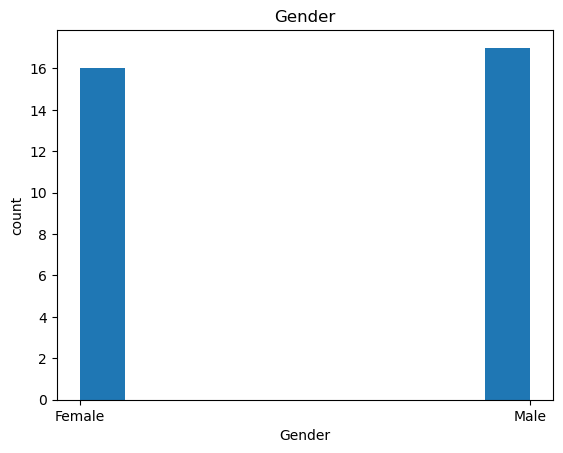

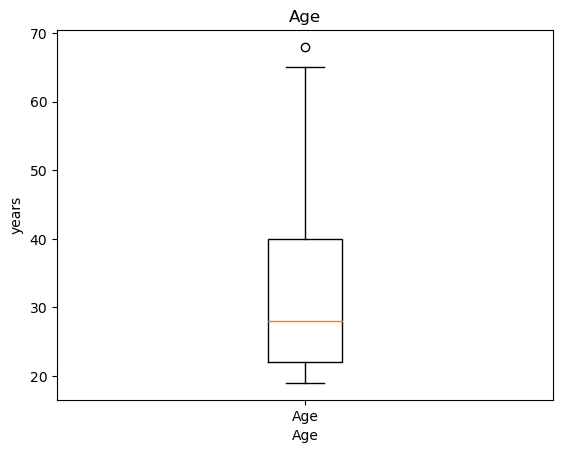

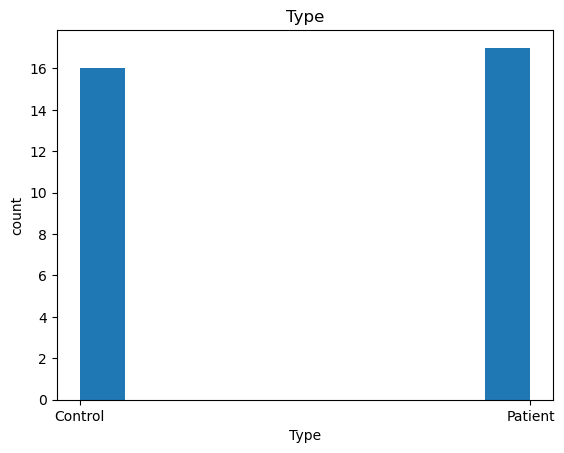

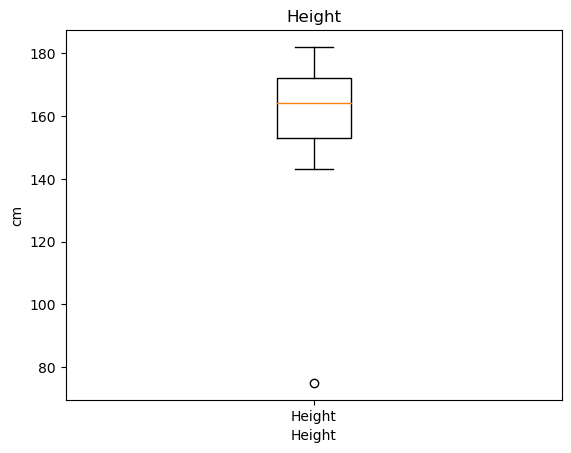

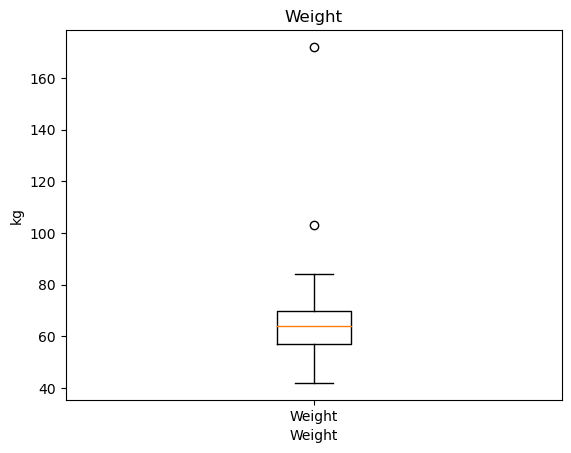

81 missing files out of 858 files, 9.44055944055944%


In [201]:
class DataStats():
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        
    def get_subjects(self) -> list:
        subjects = self.df["sub_id"].unique()
        n_subjects = len(subjects)
        
        return subjects, n_subjects
    
    def gender_stats(self) -> pd.DataFrame:
        geder_stats = self.df["subjectGender"].value_counts()
        
        self.hist_plot("Gender", "Gender", self.df["subjectGender"])
        return geder_stats
    
    def age_stats(self) -> pd.DataFrame:
        age_stats = self.df["subjectAge"].describe()
        self.box_plot("Age", "Age", "years", self.df["subjectAge"])
        return age_stats
    
    def type_stats(self) -> pd.DataFrame:  
        type_stats = self.df["subjectType"].value_counts()
        
        self.hist_plot("Type", "Type", self.df["subjectType"])
        return type_stats
    
    def body_stats(self) -> pd.DataFrame:
        height_stats = self.df["subjectHeight"].describe()
        weight_stats = self.df["subjectWeight"].describe()
        
        self.box_plot("Height", "Height", "cm", self.df["subjectHeight"])
        self.box_plot("Weight", "Weight", "kg", self.df["subjectWeight"])
        
        return height_stats, weight_stats
    
    def file_stats(self) -> pd.DataFrame:
        df = self.df.copy()
        
        col_filt = df.columns.str.contains("file_path")
        
        file_df = df.loc[:, col_filt]
        
        missing_files = file_df.applymap(lambda x: x == '-').sum().sum()
        total_files = file_df.size
        
        missing_files_percent = (missing_files / total_files) * 100
        
        return f"{missing_files} missing files out of {total_files} files, {missing_files_percent}%"
    
    def box_plot(self, title, label, unit, values):


        values = values
        labels = [label]

        plt.boxplot(values, labels=labels)
        plt.xlabel(label)
        plt.ylabel(unit)
        plt.title(title)
        plt.show()
        
    def hist_plot(self, title, label, values):
        plt.hist(values)
        plt.xlabel(label)
        plt.ylabel('count')
        plt.title(title)
        plt.show()
        
        
    def show_stats(self):
        # subjects
        print("No. of Subjects", self.get_subjects()[1])
        
        # gender stats
        self.gender_stats()
        
        # age stats
        self.age_stats()
        
        # type stats
        self.type_stats()
        
        # body stats
        self.body_stats()
        
        # file stats
        print(self.file_stats())
        

pnoistor_stats = DataStats(pnoidata_final_process.MASTER_DATA_DF)
pnoistor_stats.show_stats()